In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [96]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [97]:
# Read in Spanish names
import pandas as pd

df = pd.read_csv('names.csv')
words = df['name'].tolist()
words = [str(w) for w in words]

In [98]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: ' ', 2: "'", 3: 'A', 4: 'B', 5: 'C', 6: 'D', 7: 'E', 8: 'F', 9: 'G', 10: 'H', 11: 'I', 12: 'J', 13: 'K', 14: 'L', 15: 'M', 16: 'N', 17: 'O', 18: 'P', 19: 'Q', 20: 'R', 21: 'S', 22: 'T', 23: 'U', 24: 'V', 25: 'W', 26: 'X', 27: 'Y', 28: 'Z', 29: 'a', 30: 'n', 31: 'Ç', 32: 'Ñ', 0: '.'}
33


In [99]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([468091, 3]) torch.Size([468091])
torch.Size([58393, 3]) torch.Size([58393])
torch.Size([58650, 3]) torch.Size([58650])


In [144]:
n_embd = 20
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden)) * 0.02
b1 = torch.randn(n_hidden) * 0.02
W2 = torch.randn((n_hidden, vocab_size)) * 0.02
b2 = torch.randn(vocab_size) * 0

# Bngain and Bnbias for the model to learn how to shift the gaussian, make its peak sharper etc..
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bmean_running = torch.zeros((1, n_hidden))
bstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

19893


In [147]:
# same optimization as last time
max_steps = 40000
batch_size = 512
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1

    # batch-normalization (n_embed, n_hidden)
    # Batch-norm such that the output of the neuron is unit gaussian. Desired property as this would prevent htan from saturating
    # Preventing a neuron from "dying"
    bmeani, bstdi = hpreact.mean(dim=0, keepdim=True), hpreact.std(dim=0, keepdim=True)
    
    hpreact = bngain * ((hpreact - bmeani) / bstdi) + bnbias

    with torch.no_grad():
        bmean_running = 0.999 * bmean_running + 0.001 * bmeani
        bstd_running = 0.999 * bstd_running + 0.001 * bstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 1000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/  40000: 1.4792
   1000/  40000: 1.5406
   2000/  40000: 1.5775
   3000/  40000: 1.4940
   4000/  40000: 1.5375
   5000/  40000: 1.4785
   6000/  40000: 1.5088
   7000/  40000: 1.4874
   8000/  40000: 1.6532
   9000/  40000: 1.5635
  10000/  40000: 1.6011
  11000/  40000: 1.5484
  12000/  40000: 1.5265
  13000/  40000: 1.5103
  14000/  40000: 1.5821
  15000/  40000: 1.5335
  16000/  40000: 1.6043
  17000/  40000: 1.6137
  18000/  40000: 1.4933
  19000/  40000: 1.5724
  20000/  40000: 1.5589
  21000/  40000: 1.5517
  22000/  40000: 1.5393
  23000/  40000: 1.6159
  24000/  40000: 1.5392
  25000/  40000: 1.6081
  26000/  40000: 1.4775
  27000/  40000: 1.5363
  28000/  40000: 1.4782
  29000/  40000: 1.5432
  30000/  40000: 1.5535
  31000/  40000: 1.5431
  32000/  40000: 1.4384
  33000/  40000: 1.5386
  34000/  40000: 1.5306
  35000/  40000: 1.5110
  36000/  40000: 1.5636
  37000/  40000: 1.5270
  38000/  40000: 1.4831
  39000/  40000: 1.6466


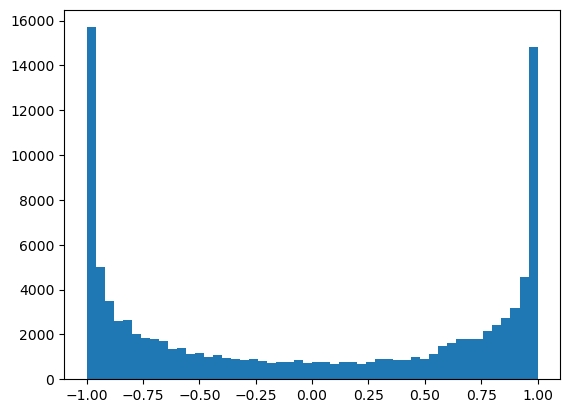

In [125]:
plt.hist(h.view(-1).tolist(), 50);

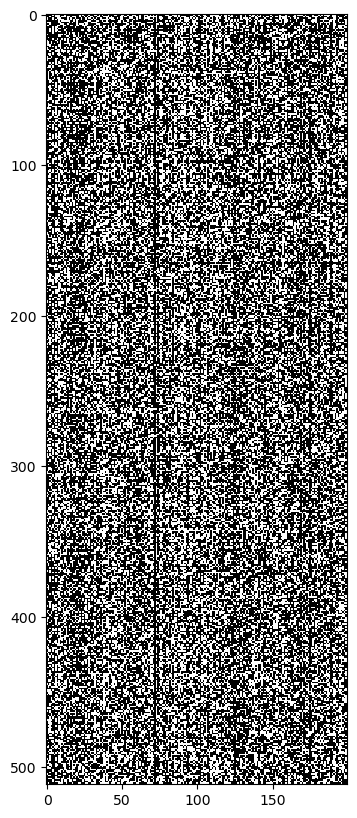

In [110]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

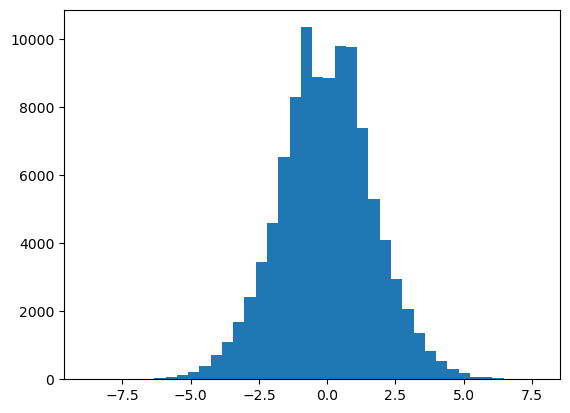

In [118]:
plt.hist(hpreact.view(-1).tolist(), 40);

In [141]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * ((hpreact - bmean_running) / bstd_running) + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.6451712846755981
val 1.6527661085128784


In [142]:
def generate_name(num):
    for _ in range(num):
        context = [0] * block_size
        name = ""

        while True:
            embd = C[torch.tensor(context)] # (1, blocksize, embed_size)
            h = torch.tanh(embd.view(-1, block_size * C.shape[-1]) @ W1 + b1)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)

            ix = torch.multinomial(probs, 1).item()
            
            if ix == 0:
                break
            
            name += itos[ix]
            context = context[1:] + [ix]
            
        print(name)


generate_name(10)

BOQRALPA NKaAMILIGTOGOMA
BLRNA BRYIMBOT OLVIH JAN
BESUSPABALVERLBN JOHQ
PBnRASUOWAY
DHUJINIBARAQUKTBPYNHIP JOSNEW
RVELDE EKZNGQAZGTEXFENKDEN
GANTOMH MADUIaZUINUB
RABÇLLSEB FERYS
MIÑOMATAJ
KLIN PHHDO
